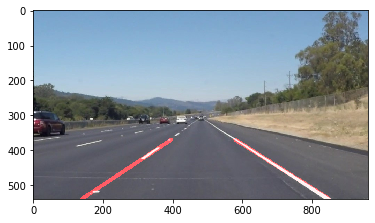

In [160]:
import sys
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
from math import exp
%matplotlib inline

M_PI = 3.1415926535898

def get_mask(cv_img):
    H, W = cv_img.shape

    mask = np.zeros((H, W))
    for i in range(H):
        for j in range(W):
            if i > (H / W) * j and i > -(H / W) * j + H:
                cv_img[i, j] = cv_img[i, j] * 1 #[i, j] = 1
            else:
                cv_img[i, j] = 0
    
    return cv_img

def get_fitline(img, f_lines): # 대표선 구하기   
    lines = np.squeeze(f_lines)
    lines = lines.reshape(lines.shape[0]*2,2)
    rows,cols = img.shape[:2]
    output = cv2.fitLine(lines,cv2.DIST_L2,0, 0.01, 0.01)
    vx, vy, x, y = output[0], output[1], output[2], output[3]
    x1, y1 = int(((img.shape[0]-1)-y)/vy*vx + x) , img.shape[0]-1
    x2, y2 = int(((img.shape[0]/2+100)-y)/vy*vx + x) , int(img.shape[0]/2+100)
    
    result = [x1,y1,x2,y2]
    return result

def draw_fit_line(img, lines, color=[255, 0, 0], thickness=10): # 대표선 그리기
        cv2.line(img, (lines[0], lines[1]), (lines[2], lines[3]), color, thickness)
        
def weighted_img(img, initial_img, α=1, β=1., λ=0.): # 두 이미지 operlap 하기
    return cv2.addWeighted(initial_img, α, img, β, λ)

def canny_edge_detecting(cv_img, threshold_LOW, threshold_HIGH):
       
    # Gaussian masking
    pGss = gaussian_2d_filtering(cv_img)
    pGss = cv2.cvtColor(pGss, cv2.COLOR_RGB2GRAY)
    
    nHeight, nWidth = pGss.shape
    nWStepG = nWidth * 1
    
    pGss = pGss.flatten()
    
    # Sobel masking
    imageMag = np.zeros(shape=(nHeight, nWidth))
    imageAng = np.zeros(shape=(nHeight, nWidth))
    
    #pMag = (np.zeros(shape=(nWidth,nHeight))).flatten()
    #pAng = (np.zeros(shape=(nWidth,nHeight))).flatten()
    
    Gx = [-1, 0, 1, -2, 0, 2, -1, 0, 1]
    Gy = [1, 2, 1, 0, 0, 0, -1, -2, -1]
    
    for r in range(0, nHeight - 1):
        pMag = imageMag[r]
        pAng = imageAng[r]
        for c in range(0, nWidth - 1):
            sumX = 0.0;
            sumY = 0.0;
            for y in range(0, 3):
                for x in range(0, 3):
                    py = r - 1 + y
                    px = c - 1 + x
                    
                    if 0 <= px < nWidth and 0 <= py < nHeight:
                        sumX += Gx[y * 3 + x] * pGss[py * nWStepG + px]
                        sumY += Gy[y * 3 + x] * pGss[py * nWStepG + px]
                    
            pMag[c] = math.sqrt(sumX * sumX + sumY * sumY)
            theta = 0.0
            if pMag[c] == 0:
                if sumY == 0:
                    theta = 0
                else:
                    theta = 90
            else:
                theta = math.atan2(sumY, sumX) * 180.0 / M_PI
            
            if (-22.5 < theta < 22.5) or theta > 157.5 or theta < -157.5:
                pAng[c] = 0
            elif (22.5 <= theta < 67.5) or (-157.5 <= theta < -112.5):
                pAng[c] = 45
            elif (67.5 <= theta < 112.5) or (-112.5 <= theta <= -67.5):
                pAng[c] = 90
            else:
                pAng[c] = 135
    
    imageCandidate = np.zeros(shape=(nHeight, nWidth))
    print(nWStepG)
    
    for r in range(1, nHeight - 1):
        pCand = imageCandidate[r]
        pMag = imageMag[r]
        pAng = imageAng[r]
        
        for c in range(1, nWidth - 1):
            # Check degree (0, 45, 90, 135)
            if pAng[c] == 0:
                if pMag[c] > pMag[c - 1] and pMag[c] > pMag[c + 1]:
                    pCand[c] = 255
            elif pAng[c] == 45:
                if pMag[c] > pMag[c - nWStepG + 1] and pMag[c] > pMag[c + nWStepG - 1]:
                    pCand[c] = 255
            elif pAng[c] == 90:
                if pMag[c] > pMag[c - nWStepG] and pMag[c] > pMag[c + nWStepG]:
                    pCand[c] = 255
            elif pAng[c] == 135:
                if pMag[c] > pMag[c - nWStepG - 1] and pMag[c] > pMag[c + nWStepG + 1]:
                    pCand[c] = 255
                    
    # Checking threshold and return result
    imageResult = np.zeros(shape=(nHeight, nWidth))
    for r in range (1, nHeight -1):
        pOut = imageResult[r]
        pMag = imageMag[r]
        pAng = imageAng[r]
        for c in range(1, nWidth - 1):
            if pCand[c] > 0:
                if pMag[c] > threshold_HIGH:
                    pOut[c] = 255
                elif pMag[c] > threshold_LOW:
                    if pAng[c] == 0:
                        if (pMag[c - nWStepG] > threshold_HIGH) or (pMag[c + nWStepG]) > threshold_HIGH:
                            pOut = 255
                    elif pAng[c] == 45:
                        if (pMag[c - nWStepG - 1] > threshold_HIGH) or (pMag[c + nWStepG + 1]) > threshold_HIGH:
                            pOut = 255
                    elif pAng[c] == 90:
                        if (pMag[c - 1] > threshold_HIGH) or (pMag[c + 1] > threshold_HIGH):
                            pOut = 255
                    elif pAng[c] == 135:
                        if (pMag[c-nWStepG + 1] > threshold_HIGH) or (pMag[c + nWStepG - 1] > threshold_HIGH):
                            pOut = 255
    
    #pResult = pResult.reshape(nHeight,nWidth)
    #pResult = pAng.reshape(nHeight,nWidth)
    imageResult = imageResult.astype('uint8')
    
    return imageResult

def draw_lines(img, lines, color=[0, 0, 255], thickness=2): # 선 그리기
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap): # 허프 변환
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)

    return line_img

def gaussian_2d_filtering(cv_img, deviation = 0.4):
    nHeight, nWidth, nChannel = cv_img.shape
    
    m_bufGss = [0,0,0,0,0,0,0,0,0,0,0,0,0]
    
    m_dGaussian = deviation
    
    nHalf = int(max((m_dGaussian * 6 - 1) / 2, 1))
    nWstep = nWidth * nChannel
    
    pIn = cv_img.flatten()
    pTmp = (np.zeros(shape=(nWidth,nHeight,nChannel))).flatten()
    pOut = (np.zeros(shape=(nWidth,nHeight,nChannel))).flatten()
    
    n = 0
    while n <= nHalf:
      m_bufGss[nHalf - n] = m_bufGss[nHalf + n] = exp((-1 * n) * n / (2 * m_dGaussian*m_dGaussian)) 
      n += 1 

    for r in range(0, nHeight):
      for c in range(0, nWidth):
        for l in range(0, nChannel):
          dSum = dGss = 0
    
          for n in range(-1 * nHalf, nHalf+1):
            px = c + n
            
            if 0 <= px < nWidth:
                dSum += (pIn[nWstep * r + nChannel * px + l] * m_bufGss[nHalf + n])
                dGss += m_bufGss[nHalf + n]
          
          pTmp[nWstep * r + nChannel * c + l] = int(dSum / dGss)
    
    for r in range(0, nHeight):
      for c in range(0, nWidth):
        for l in range(0, nChannel):
          dSum = dGss = 0
    
          for n in range(-1 * nHalf, nHalf+1):
            py = r + n
            if 0 <= py < nHeight:
              absN = abs(n)
              dSum += (pTmp[nWstep * py + nChannel * c + l] * m_bufGss[nHalf + absN])
              dGss += m_bufGss[nHalf + absN]
            
          pOut[nWstep * r + nChannel * c + l] = int(dSum / dGss)
    np.set_printoptions(threshold=sys.maxsize)
    
    pResult = pOut.reshape(nHeight,nWidth,nChannel)
    pResult = pResult.astype('uint8')
    
    return pResult

cv_img = cv2.imread('road.jpg')
cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)

## Implemented gaussian blur ( very slow ) 
# pResult = gaussian_2d_filtering(cv_img, 2)

## OpenCV gaussian blur library ( fast & good )
pResult = cv2.GaussianBlur(cv_img, (9, 9),10)

## Canny Edge detect ( Not working yet T_T )
#pResult = canny_edge_detecting(cv_img, 0, 50)
#plt.imshow(pResult, cmap='gray')

## Canny Edge detect by openCV library
pResult = cv2.cvtColor(pResult, cv2.COLOR_RGB2GRAY)
pResult = cv2.Canny(pResult, 50, 100)

## Mask Lane ROI
pResult = get_mask(pResult)

lines = cv2.HoughLinesP(pResult, 1, np.pi/180, 30)

line_arr = np.squeeze(lines)
slope_degree = (np.arctan2(line_arr[:,1] - line_arr[:,3], line_arr[:,0] - line_arr[:,2]) * 180) / np.pi

line_arr = line_arr[np.abs(slope_degree)<160]
slope_degree = slope_degree[np.abs(slope_degree)<160]

line_arr = line_arr[np.abs(slope_degree)>95]
slope_degree = slope_degree[np.abs(slope_degree)>95]

L_lines, R_lines = line_arr[(slope_degree>0),:], line_arr[(slope_degree<0),:]
temp = np.zeros((cv_img.shape[0], cv_img.shape[1], 3), dtype=np.uint8)
L_lines, R_lines = L_lines[:,None], R_lines[:,None]

left_fit_line = get_fitline(cv_img,L_lines)
right_fit_line = get_fitline(cv_img,R_lines)

draw_fit_line(temp, left_fit_line)
draw_fit_line(temp, right_fit_line)

result = weighted_img(temp, cv_img)

plt.imshow(result)